# Normalization Methods in Deep Learning

I've ran into three general methods of normalizing data in deep learning. They are:
1. Input normalization
2. Batch Normalization
3. Layer Normalization
4. Root Mean Square Normalization (RMS Norm)

### What is Normalization?
Normalization refers to the process of scaling input data to a standard range or distribution. The goal of normalization is to make the data more consistent and easier to work with, which can lead to better performance and stability during training.

### Why Normalize?
Normalization techniques ensure that the input features or activations have a similar scale, which helps prevent certain features from dominating the learning process due to their larger magnitudes. This is particularly important when dealing with numerical features that may have different scales or distributions. Because although correct initialization can set us up for success, it doesn't mean that the problems won't arise during training.

The normalization process helps model development in the following ways:
1. It mitigates the vanishing gradient problem
   - With so many layers, gradients can become very small, or very large. Normalization can help keep the gradients in within a reasonable range, ensuringe more stable training.
2. It helps the model converge faster
   - Normalizaing the inputs to each layer or batch can speed convergest of the optimization algorithm. When all of the data is within a smaller range, the search space becomes smaller.
3. Applies a form of regularization
   - Normalization can force the model to not 
4. Stabilizes the learning process
   - Can reduce the sensitivity of the model to the initial weights and biases (avoiding lotter ticket hypothesis)
5. Allows for larger learning rates
   - By mitigating the vanishing gradient problem, larger learning rates can be used, which can speed up the training process.

### Where to Normalize?
Normalization can be applied at different levels of the network.

1. Batch Normalization (Batch Norm):
   - Batch Norm is typically applied before the activation function. The normalization process involves computing the mean and variance of each feature within a mini-batch and then normalizing the activations based on these statistics.
   Placing Batch Norm before the activation function helps ensure that the activations are normalized before being passed through the non-linearity, which can stabilize training and improve performance.
   - If we use a Batch Norm at the begining of our network, we can avoid the need for input normalization.

2. Layer Normalization:
   - Layer Norm is applied either before or after the activation function, depending on the architecture and task.
   In feedforward neural networks, Layer Norm is often applied after the activation function, normalizing the activations of each layer across all examples in a batch.
   - In recurrent neural networks (RNNs) or Transformers, Layer Norm is typically applied before the activation function, normalizing the activations across the hidden states or feature dimensions of each time step.

3. RMS Normalization:
   - Extension of Layer Normalization, but allegidly 7% - 64% faster than Layer Normalization. 
   - In the LLaMA model, The layer norm was applied at the input  of each transformer sub-layer, rather than at the output.

# References:

Géron, Aurélien. Hands-On Machine Learning with Scikit-Learn, Keras, and TensorFlow, 2nd Edition. O’Reilly Media, Incorporated, 2019.

https://akgeni.medium.com/llama-concepts-explained-summary-a87f0bd61964

In [ ]:
import torch
import torch.nn as nn
from torch.utils.data import Dataset

# Input Normalization:
* Purpose: Input normalization techniques such as scaling data between 0 and 1 or using StandardScaler aim to preprocess input features, ensuring they are on a consistent scale to improve model performance and stability.

* Normalization Strategy: Scaling data between 0 and 1 involves linearly transforming feature values, while StandardScaler standardizes features by removing the mean and scaling to unit variance, both techniques crucial for mitigating feature dominance and ensuring robustness across different feature scales.

* Applicability: These techniques are widely applicable in various machine learning tasks, with scaling data between 0 and 1 preferred for bounded feature distributions and StandardScaler for unbounded or Gaussian-distributed features.

In [ ]:
class StandardizeDataset(Dataset):
    def __init__(self, dataset, mean, std):
        self.dataset = dataset
        self.mean = mean
        self.std = std

    def __len__(self):
        return len(self.dataset)

    def __getitem__(self, idx):
        img, label = self.dataset[idx]
        img = (img - self.mean) / self.std
        return img, label

# Batch Normalization

Purpose:

* BatchNorm is primarily used to address the internal covariate shift problem in deep neural networks by normalizing the activations of each layer across mini-batches during training.
Normalization Strategy:

* BatchNorm normalizes the activations across the mini-batch dimension. It calculates the mean and standard deviation of each feature across the mini-batch and normalizes the features using these statistics.

Learnable Parameters:

* BatchNorm introduces learnable parameters (scale and shift) to the normalized data, allowing the model to adapt and learn the optimal normalization for each layer.

Applicability:

* BatchNorm is commonly used in deep neural networks, especially in convolutional neural networks (CNNs) and recurrent neural networks (RNNs).

Performance:

* BatchNorm can suffer from issues such as batch size sensitivity during inference and training instability in small batch sizes.

### References:

[Batch Normalization: Accelerating Deep Network Training by Reducing Internal Covariate Shift](https://arxiv.org/abs/1502.03167)

In [ ]:
class BatchNorm1d(nn.Module):
    def __init__(self, num_features, eps=1e-5, momentum=0.1):
        super().__init__()
        self.num_features = num_features
        self.eps = eps
        self.momentum = momentum

        # Initialize parameters
        self.gamma = nn.Parameter(torch.ones(num_features))
        self.beta = nn.Parameter(torch.zeros(num_features))
        self.register_buffer('running_mean', torch.zeros(num_features))
        self.register_buffer('running_var', torch.ones(num_features))

    def forward(self, x):
        if self.training:
            mean = x.mean(dim=0, keepdim=True)
            var = x.var(dim=0, unbiased=False, keepdim=True)
            self.running_mean = (1 - self.momentum) * self.running_mean + self.momentum * mean.squeeze()
            self.running_var = (1 - self.momentum) * self.running_var + self.momentum * var.squeeze()
        else:
            mean = self.running_mean.unsqueeze(0)
            var = self.running_var.unsqueeze(0)

        x_normalized = (x - mean) / torch.sqrt(var + self.eps)
        output = self.gamma * x_normalized + self.beta
        return output

# Layer Normalization:

Layer Normalization is similar to Batch normalization but instead of normalizing across the batch dimension, layer normalization normalizes across the feature dimension. This can be computed on the fly, at each step, independently for each instance. This means it behaves the same way during training and testing (unlike Batch Normalization).

Purpose:

* LayerNorm normalizes the activations of each layer across feature dimensions independently for each sample in a mini-batch. It aims to stabilize the training process and reduce the impact of the scale of input features.

Normalization Strategy:

* LayerNorm normalizes the activations across the feature dimension independently for each sample in the mini-batch. It calculates the mean and standard deviation of each feature across the feature dimension and normalizes the features using these statistics.

Learnable Parameters:

* LayerNorm does not introduce any learnable parameters. It normalizes the activations based solely on the mean and standard deviation computed across the feature dimension.

Applicability:

* LayerNorm is often used in natural language processing (NLP) tasks, such as sequence modeling and language understanding, where the feature dimensions can vary across samples.

Performance:

* LayerNorm is less sensitive to batch size and performs well even in small batch sizes. It can also be applied in scenarios where the sequence length varies across samples.

### References:
[PyTorch LAYERNORM Documentation](https://pytorch.org/docs/stable/generated/torch.nn.LayerNorm.html#torch.nn.LayerNorm)

[Layer Normalization Paper](https://arxiv.org/abs/1607.06450)

In [ ]:
class LayerNorm(nn.Module):
    def __init__(self, normalized_shape:tuple, eps=1e-6):
        super().__init__()
        self.normalized_shape = normalized_shape
        self.eps = eps
        self.gain = nn.Parameter(torch.ones(normalized_shape))
        self.bias = nn.Parameter(torch.zeros(normalized_shape))

    def forward(self, x):
        mean = x.mean(dim=-1, keepdim=True)
        std = x.std(dim=-1, keepdim=True)
        return (x - mean) / (std + self.eps) * self.gain + self.bias

# Root Mean Square Normalization:

The paper suggests that the rescaling of invariance  is the reason for success, not the recentering (x - E[x]) and rescaling (x / std(x)) of the data. RMS Norm simplifies the normalization process by removing the need for a mean statistic. 

This does not need a bias like the Layer norm because it will be passed through the linear layer and the bias will be learned there.

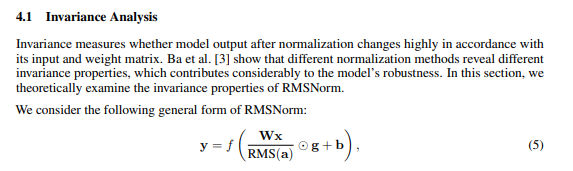

Let first understand LayerNorm, It has two properties.

    a. re-centring : It make model insensitive to shift noises on both inputs and weights.

    b. re-scaling: It keeps the output representations intact when both inputs and weights are randomly scaled.

RMSNorm claims that most of the benefits comes from re-scaling.

RMSNorm does re-scaling invariance and regularizes the summed
inputs simply according to the root mean square (RMS) statistic.

## Use Cases:
- Llama 2 uses RMS norm at the end of every decoder layer.

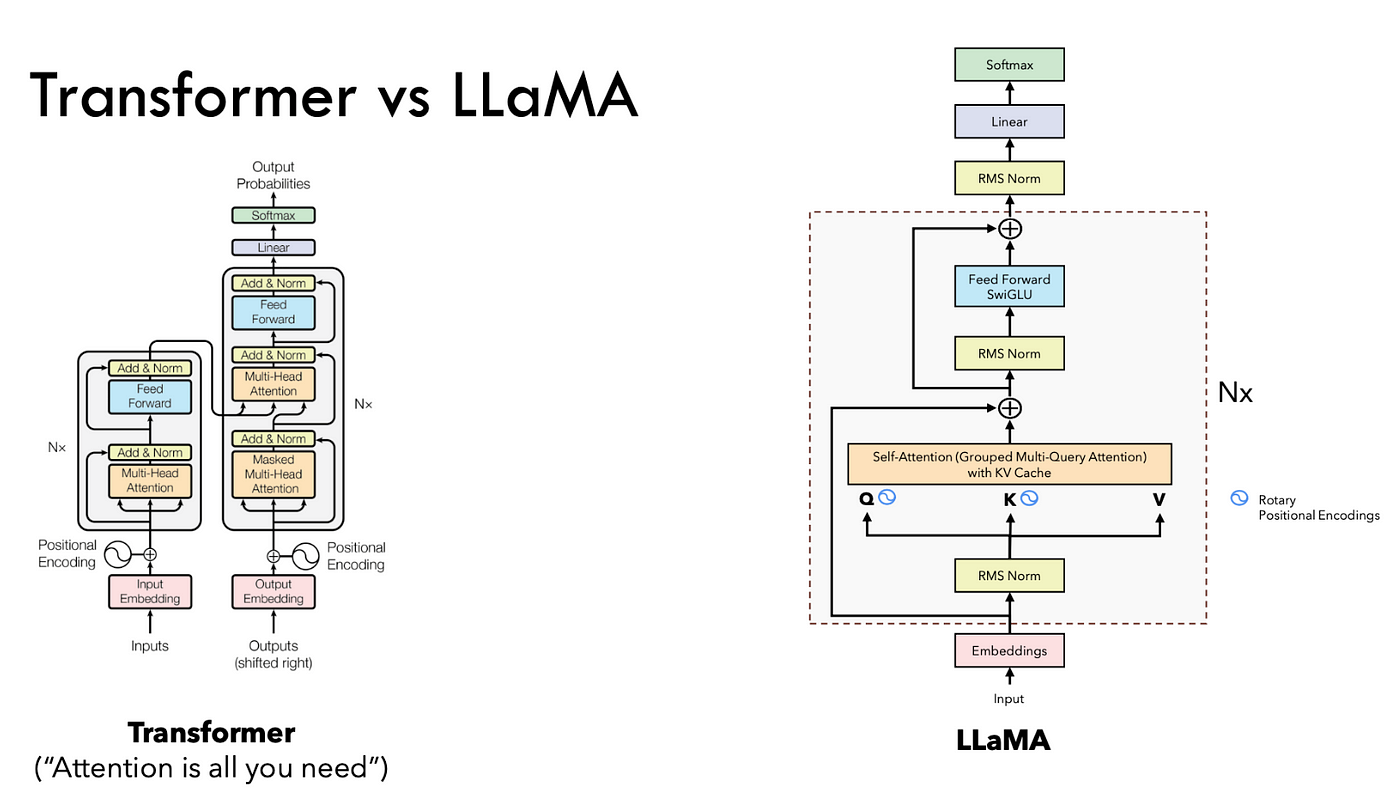

- Gemma uses RMS norm at the beginning AND end of decoder layer.

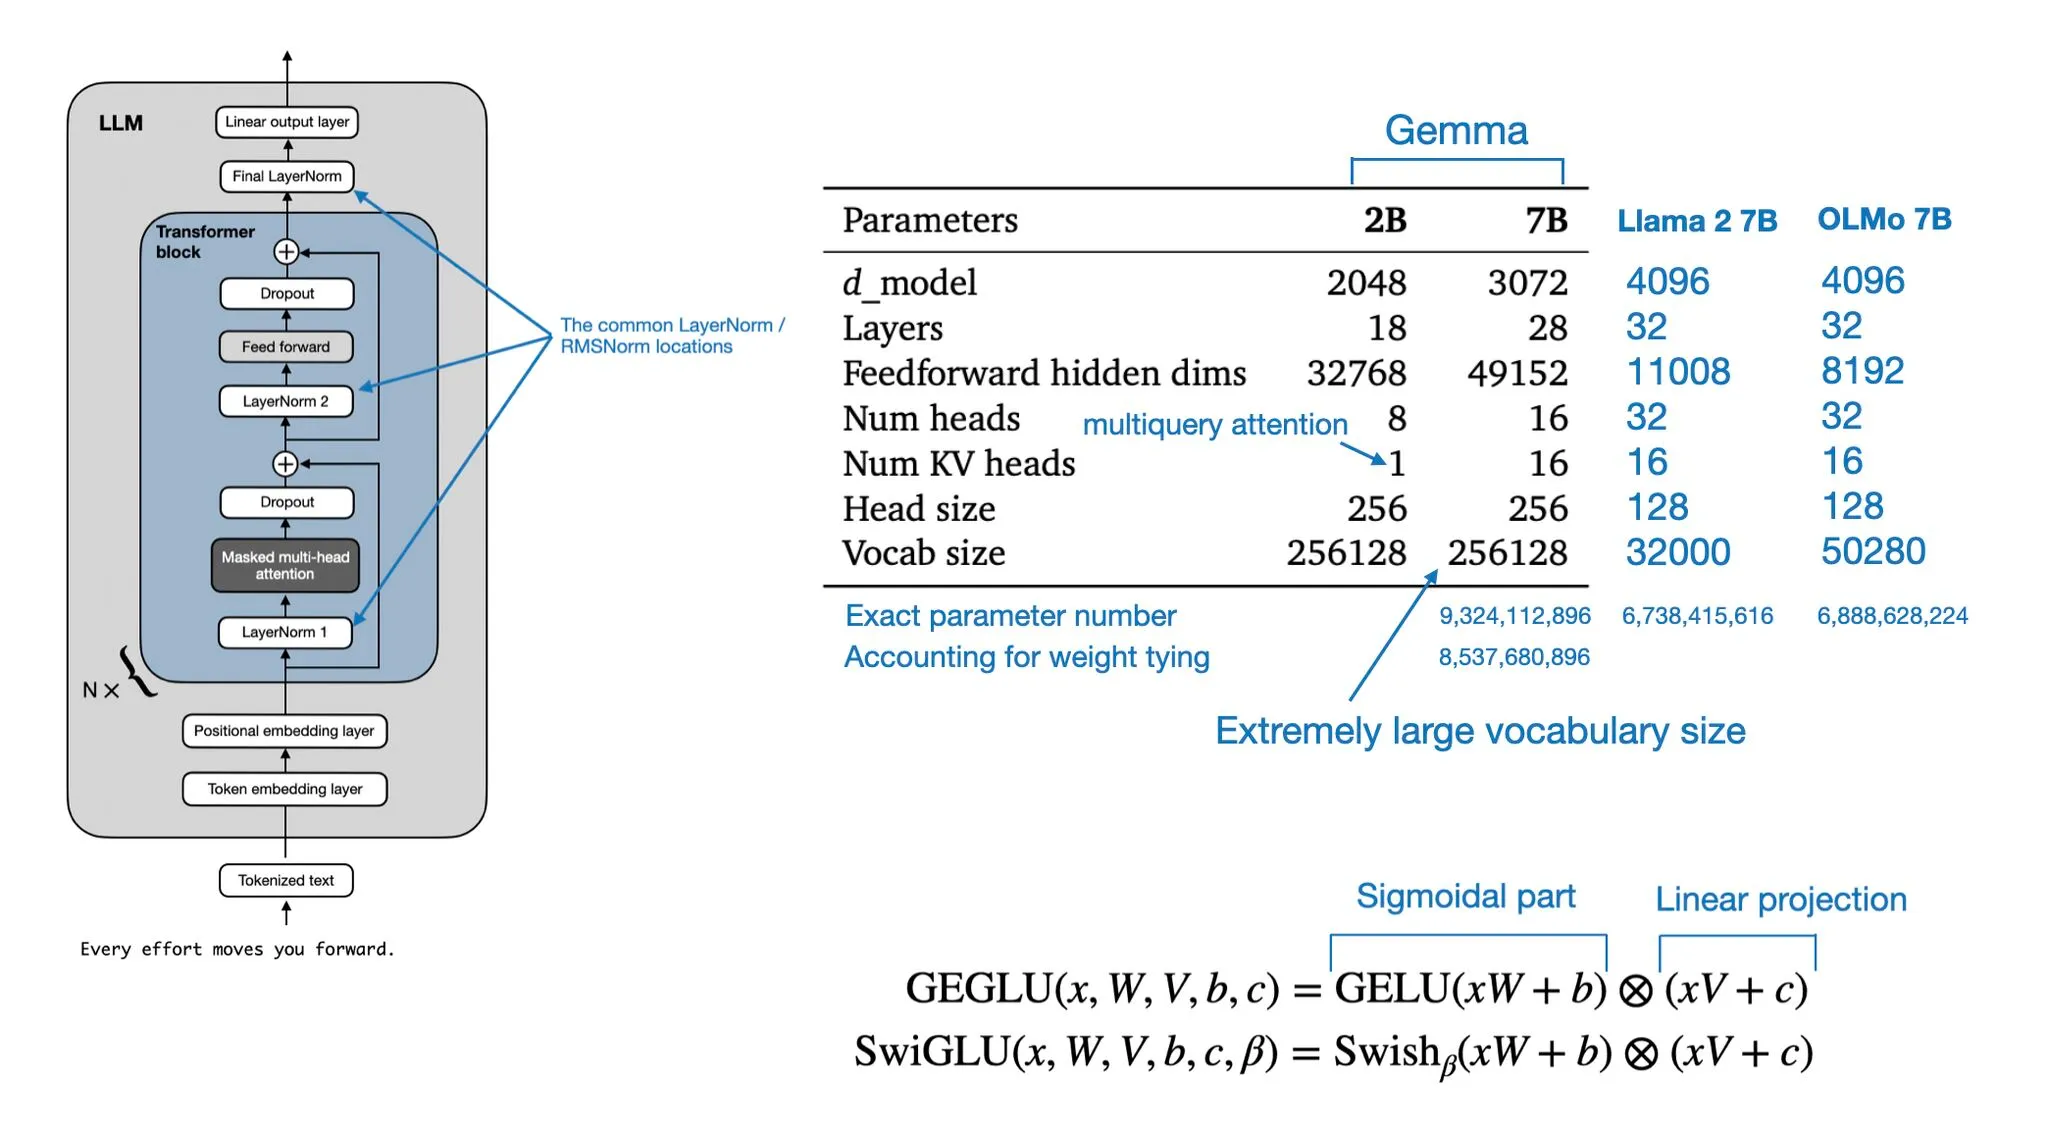


## Purpose:

- RMSNorm normalizes the inputs by dividing them by the root mean square (RMS) value along a specific axis, typically along the feature dimension. It aims to stabilize and accelerate training by normalizing the magnitude of the inputs.

Normalization Strategy:

- RMSNorm normalizes the inputs by dividing them by the root mean square (RMS) value along a specific axis, typically along the feature dimension. It calculates the RMS value of each feature along the specified axis and normalizes the features using these RMS values.

Learnable Parameters:

- RMSNorm introduces a single learnable parameter, gain, to scale the normalized data, but it does not introduce any parameter to shift the data.

Applicability:

- RMSNorm is less common compared to BatchNorm and LayerNorm but can be useful in scenarios where stabilizing the magnitude of inputs is beneficial, such as in reinforcement learning or certain types of recurrent neural networks.

Performance:

- RMSNorm is relatively simple and computationally efficient compared to BatchNorm and LayerNorm. It can provide stable performance across different batch sizes and input dimensions.

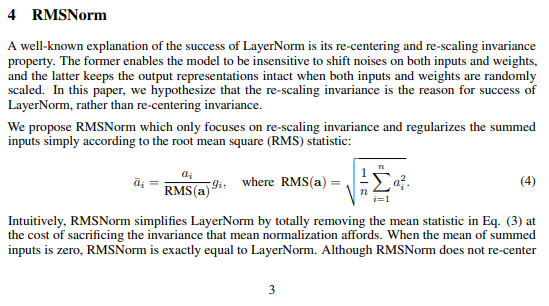

### References:

[Root Mean Square Layer Normalization](https://arxiv.org/abs/1910.07467)

[Gemma: Introducing new state-of-the-art open model by Google](https://medium.com/@shravankoninti/gemma-introducing-new-state-of-the-art-open-model-by-google-caae9fe29972)

In [ ]:
class RMSNorm(nn.Module):
    def __init__(self, normalized_shape: int, eps: float = 1e-6):
        super().__init__()
        self.eps = eps
        self.gain = nn.Parameter(torch.ones(normalized_shape))

    def forward(self, x: torch.Tensor):
        rms = torch.sqrt((torch.mean(x.pow(2), dim=-1, keepdim=True) + self.eps) / (x.size(-1)))
        return (x / rms) * self.gain